# Butterfly Classification Using Xception

## Data Loading

In [1]:
# Exporting dataset via kaggle

!kaggle datasets download -d gpiosenka/butterfly-images40-species

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species
License(s): CC0-1.0
100% 399M/399M [00:21<00:00, 23.4MB/s]
100% 399M/399M [00:21<00:00, 19.8MB/s]


In [2]:
# Exporting dataset from zipfile

import zipfile
zip_ref = zipfile.ZipFile('/content/butterfly-images40-species.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Prepataion

In [3]:
# Importing Necessory Libraries

import os
import time
import shutil
import pathlib
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [4]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [5]:
# Data Augmentation

def create_gens(train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)

    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen


train_dir = '/content/train'
valid_dir = '/content/valid'
test_dir =  '/content/test'

train_df = create_df(train_dir)
valid_df = create_df(valid_dir)
test_df = create_df(test_dir)

batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 12594 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


## Data Visualization

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

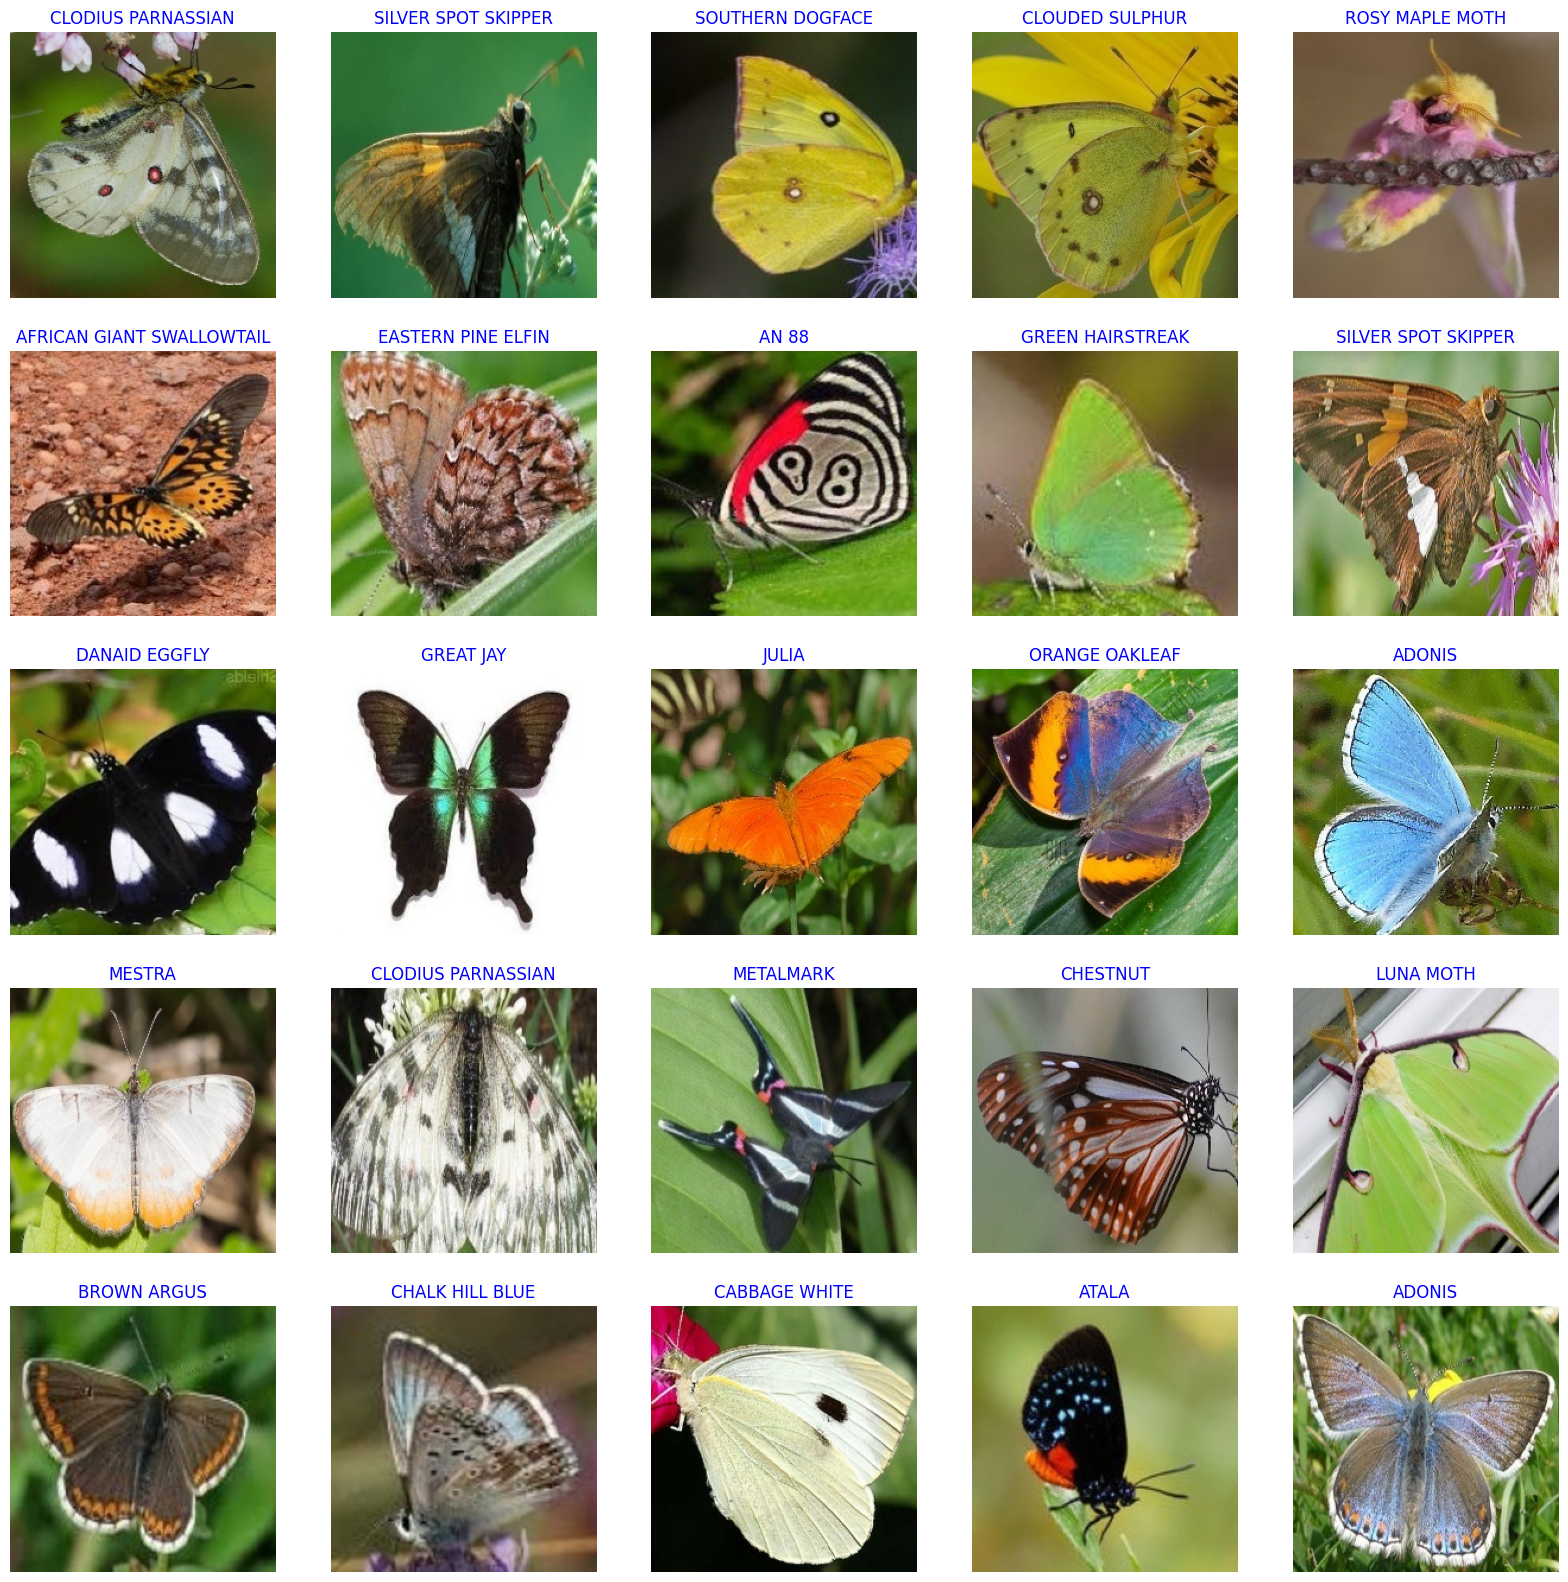

In [ ]:
show_images(train_gen)

## Model Building

### EfficientNetB3

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = Sequential([

    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')

])

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,206,099 (42.75 MB)

 Trainable params: 419,492 (1.60 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=30,
    verbose=1,
    validation_data=valid_gen,
)

Epoch 1/30


I0000 00:00:1739278568.566357    2758 service.cc:148] XLA service 0x7f0ee807c490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739278568.566384    2758 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-02-11 18:26:08.972396: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739278570.493758    2758 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/315 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.0069 - loss: 5.0815     

I0000 00:00:1739278584.795134    2758 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 ━━━━━━━━━━━━━━━━━━━━ 72s 149ms/step - accuracy: 0.1949 - loss: 3.6295 - val_accuracy: 0.7540 - val_loss: 0.9809
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.5704 - loss: 1.5649 - val_accuracy: 0.8340 - val_loss: 0.6110
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.6879 - loss: 1.1091 - val_accuracy: 0.8500 - val_loss: 0.4986
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.7295 - loss: 0.9211 - val_accuracy: 0.8840 - val_loss: 0.4339
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7472 - loss: 0.8274 - val_accuracy: 0.8840 - val_loss: 0.4065
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.7827 - loss: 0.7024 - val_accuracy: 0.8820 - val_loss: 0.3827
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7881 - loss: 0.6717 - val_accuracy: 0.8960 - val_loss: 0.3742
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8044 - loss: 0.6252 - val_accura

In [ ]:
history_df = pd.DataFrame(history.history)

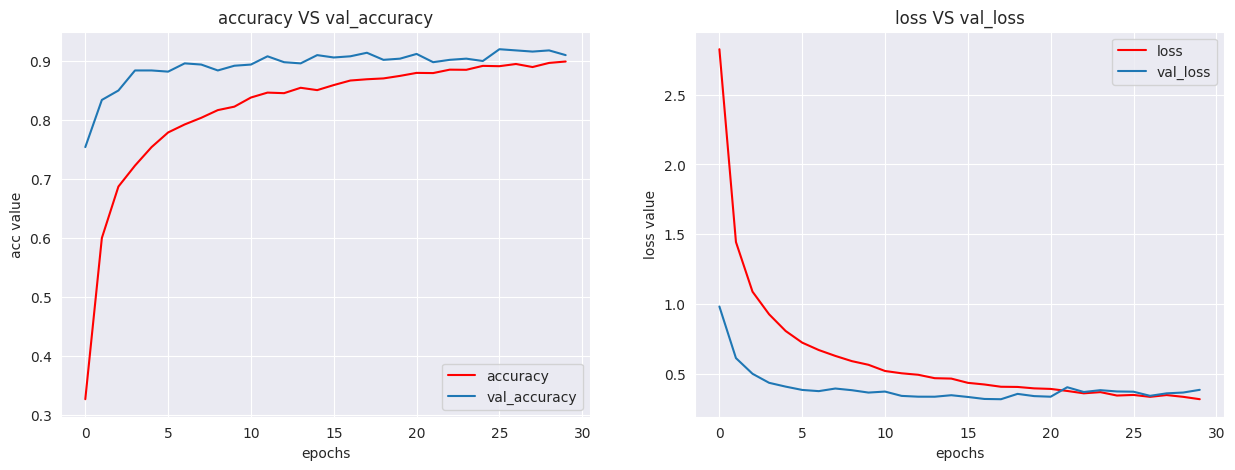

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

### Xception

In [10]:
def create_model(model_name, verbose=False):

    input_tensor = Input(shape=(224, 224, 3))

    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')

    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(100, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model

In [11]:
xception_model = create_model(model_name='xception', verbose=False)
xception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
xception_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 23,062,156 (87.98 MB)

 Trainable params: 23,007,628 (87.77 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [13]:
history = xception_model.fit(
    x=train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
)

Epoch 1/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 250s 661ms/step - accuracy: 0.4177 - loss: 2.5817 - val_accuracy: 0.6980 - val_loss: 1.2813
Epoch 2/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 171s 541ms/step - accuracy: 0.8492 - loss: 0.5490 - val_accuracy: 0.8520 - val_loss: 0.6158
Epoch 3/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 171s 542ms/step - accuracy: 0.8929 - loss: 0.3705 - val_accuracy: 0.9000 - val_loss: 0.4274
Epoch 4/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 171s 542ms/step - accuracy: 0.9109 - loss: 0.3204 - val_accuracy: 0.8960 - val_loss: 0.4648
Epoch 5/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 171s 542ms/step - accuracy: 0.9319 - loss: 0.2358 - val_accuracy: 0.8880 - val_loss: 0.4834
Epoch 6/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 203s 544ms/step - accuracy: 0.9365 - loss: 0.2292 - val_accuracy: 0.8980 - val_loss: 0.6671
Epoch 7/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 171s 542ms/step - accuracy: 0.9417 - loss: 0.2251 - val_accuracy: 0.9180 - val_loss: 0.3337
Epoch 8/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 202s 543ms/step - accuracy: 0.9463 -

In [14]:
history_df = pd.DataFrame(history.history)

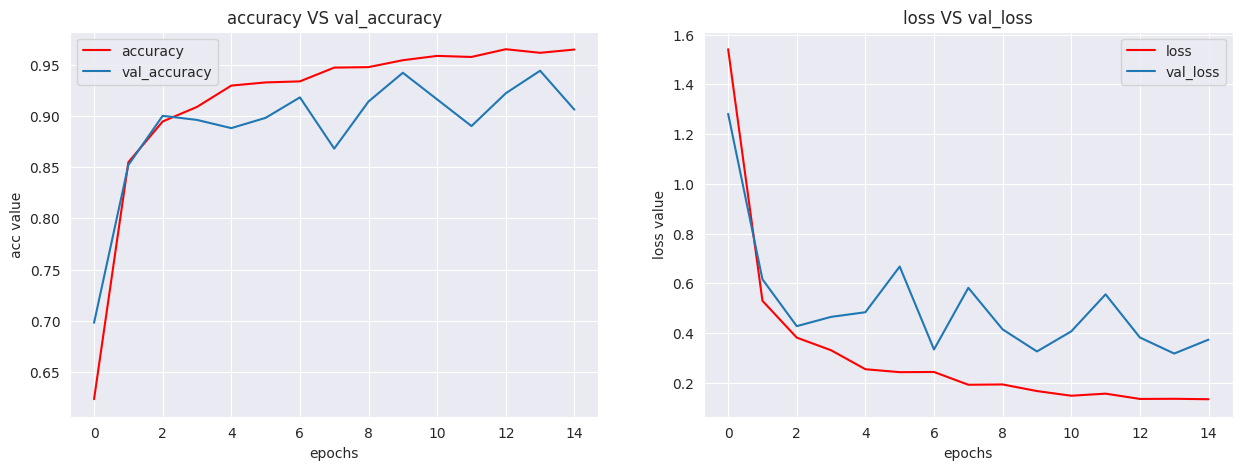

In [15]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()